# Dataset


In [1]:
# Imports


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

import math
import seaborn as sns
import warnings                   # To ignore the warnings
import pandas as pd
import numpy as np          # For mathematical calculations
import matplotlib.pyplot as plt  # For plotting graphs
from datetime import datetime    # To access datetime
from pandas import Series        # To work on series

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from xgboost import XGBClassifier

# import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline
warnings.filterwarnings("ignore")


In [2]:
# Data extraction

train_layer_9 = pd.read_csv("../data/layer10/train_10.csv")
test_layer_9 = pd.read_csv("../data/layer10/test_10.csv")
valid_layer_9 = pd.read_csv("../data/layer10/valid_10.csv")

In [3]:
# Extracting x and y

x_train = train_layer_9.copy().drop(
    columns=["label_1", "label_2", "label_3", "label_4"]
)
x_valid = valid_layer_9.copy().drop(
    columns=["label_1", "label_2", "label_3", "label_4"]
)
x_feature_names = ["feature_" + str(i) for i in range(1, 769)]

id_train = train_layer_9["label_1"].to_frame()
age_train = train_layer_9["label_2"].to_frame()  # id has NaN
gender_train = train_layer_9["label_3"].to_frame()
accent_train = train_layer_9["label_4"].to_frame()  # Accent has bias to 6

id_valid = valid_layer_9["label_1"].to_frame()
age_valid = valid_layer_9["label_2"].to_frame()
gender_valid = valid_layer_9["label_3"].to_frame()
accent_valid = valid_layer_9["label_4"].to_frame()

In [4]:
# Scaling using RobustScaler
scaler_robust = RobustScaler()
scaler_robust.fit(x_train)

x_train_scaled = pd.DataFrame(scaler_robust.transform(x_train), columns=x_feature_names)
x_valid_scaled = pd.DataFrame(scaler_robust.transform(x_valid), columns=x_feature_names)

x_test = test_layer_9.copy().drop(columns=["ID"])
x_test_scaled = pd.DataFrame(scaler_robust.transform(x_test), columns=x_feature_names)

In [5]:
age_train[age_train["label_2"].isnull()].shape

(480, 1)

### Support Functions


In [7]:
def validate_model(model, x_valid, y_valid):
    y_pred = model.predict(x_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    print("Accuracy: ", accuracy)
    cm = confusion_matrix(y_valid, y_pred)
    print("Confusion matrix: ")
    print(cm)
    print("Precision, recall, f1-score: ")
    prfs_ = precision_recall_fscore_support(y_valid, y_pred, average="weighted")
    return prfs_, cm

In [7]:
def do_pca(train, valid, variance: float = None, n_components: int = None):
    pca_obj = PCA(n_components=0.99, svd_solver="full")
    if variance:
        pca_obj = PCA(n_components=variance, svd_solver="full")
    elif n_components:
        pca_obj = PCA(n_components=n_components)
    pca_obj.fit(train)
    n_components = pca_obj.components_.shape[0]

    x_train = pd.DataFrame(
        pca_obj.transform(train),
        columns=["feature_pca_" + str(i) for i in range(1, n_components + 1)],
    )
    x_valid = pd.DataFrame(
        pca_obj.transform(valid),
        columns=["feature_pca_" + str(i) for i in range(1, n_components + 1)],
    )

    return x_train, x_valid, n_components, pca_obj

In [8]:
def fit_and_score(classifier_models, x_train, x_valid, y_train, y_valid):
    """
    Fits and evaluates given classifier models.
    classifier_models : a dict of different Scikit-Learn classifier models
    x_train : training data (no labels)
    x_valid : validation data (no labels)
    y_train : training labels
    y_valid : validation labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    classifier_model_scores = {}
    # Loop through classifier_models
    for name, model in classifier_models.items():
        print(f"Fitting {name}...")
        # Fit the model to the data
        model.fit(x_train, y_train)
        # Evaluate the model and append its score to classifier_model_scores
        classifier_model_scores[name] = model.score(x_valid, y_valid)
        print("Done fitting and scoring model.")
    return classifier_model_scores

In [9]:
def tune_hyperparameters(classifier_models, grid, x_train, x_valid, y_train, y_valid):
    """
    Fits and evaluates given classifier models.
    classifier_models : a dict of different Scikit-Learn classifier models
    grid : a dict of hyperparameters to tune
    x_train : training data (no labels)
    x_valid : validation data (no labels)
    y_train : training labels
    y_valid : validation labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    classifier_model_scores = {}
    trained_searches = {}
    # Loop through classifier_models
    for name, model in classifier_models.items():
        # Setup random hyperparameter search for model
        rs_model = RandomizedSearchCV(
            estimator=model,
            param_distributions=grid,
            n_iter=20,
            cv=5,
            verbose=3,
            random_state=42,
            n_jobs=-1,
        )
        # Fit random hyperparameter search model
        fileName = name + "_rs_model" + ".pkl"
        rs_model.fit(x_train, y_train)
        # Export rs_model using joblib
        joblib.dump(rs_model, fileName)
        trained_searches[name] = rs_model

        # Evaluate the model and append its score to classifier_model_scores
        classifier_model_scores[name] = rs_model.score(x_valid, y_valid)
        print("classifier model scores", classifier_model_scores)
    return trained_searches

In [10]:
def write_test_pred_to_csv(model, x_test, csv_name="test_pred.csv"):
    y_pred = model.predict(x_test)
    y_pred = pd.DataFrame(y_pred, columns=["label"])
    y_pred.to_csv(csv_name, index=False)

In [11]:
def find_min_pca_components(
    x_train, x_valid, y_train, y_valid, threshold: float = 0.90
):
    # Find min number of components for 90% accuracy
    score = 1

    while score > threshold:
        x_train, x_valid, id_n_components, id_pca_cat = do_pca(
            x_train, x_valid, variance=0.95
        )

        print("Number of components: ", id_n_components)

        id_final = SVC()
        id_final.fit(x_train, y_train)

        precision_recall_fscore_svc_final, cm_final = validate_model(
            id_final, x_valid, y_valid
        )

        print("Precision, Recall and F1 Score:", precision_recall_fscore_svc_final)

        y_pred = id_final.predict(x_valid)
        score = accuracy_score(y_valid, y_pred)
        print("Accuracy: ", score)

    print("Final number of components: ", id_n_components)
    print("Final Precision, Recall and F1 Score:", precision_recall_fscore_svc_final)
    return id_n_components, id_pca_cat

# Label 1


use {'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 10}


In [12]:
import shap

In [13]:
id_data_train_cat = pd.concat([x_train_scaled, id_train], axis=1)
id_data_valid_cat = pd.concat([x_valid_scaled, id_valid], axis=1)

# Remove rows with null values
id_data_cleaned_train_cat = id_data_train_cat.dropna()
id_data_cleaned_valid_cat = id_data_valid_cat.dropna()

# Separate X and y again
id_x_train_cat = id_data_cleaned_train_cat.drop(columns=["label_1"])
id_y_train_cat = id_data_cleaned_train_cat["label_1"]
id_x_valid_cat = id_data_cleaned_valid_cat.drop(columns=["label_1"])
id_y_valid_cat = id_data_cleaned_valid_cat["label_1"].to_frame()

id_x_test_cat = x_test_scaled

### Initial Model SVC


In [14]:
id_initial = SVC(kernel="rbf", C=20, gamma="scale")
# {'kernel': 'rbf', 'gamma': 'scale', 'C': 20}
id_initial.fit(id_x_train_cat, id_y_train_cat)

SVC(C=20)

In [15]:
precision_recall_fscore_svc_initial, cm_initial = validate_model(
    id_initial, id_x_valid_cat, id_y_valid_cat
)

print("Precision, Recall and F1 Score:", precision_recall_fscore_svc_initial)
# Accuracy:  0.9573333333333334 ->

Accuracy:  0.968
Confusion matrix: 
[[12  0  0 ...  0  0  0]
 [ 0  9  0 ...  0  0  0]
 [ 0  0 12 ...  0  0  0]
 ...
 [ 0  0  0 ... 20  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0 10]]
Precision, recall, f1-score: 
Precision, Recall and F1 Score: (0.9710426720052107, 0.968, 0.9681729568549567, None)


In [16]:
id_initial_test_preds = id_initial.predict(id_x_valid_cat)
pd.DataFrame(id_initial_test_preds, columns=["label_1"]).to_csv(
    "id_initial_valid_preds.csv"
)

### Data Processing - PCA


In [17]:
id_x_train_pca, id_x_valid_pca, id_n_components, id_pca_cat = do_pca(
    id_x_train_cat, id_x_valid_cat, n_components=70
)
id_x_test_pca = pd.DataFrame(
    id_pca_cat.transform(id_x_test_cat),
    columns=["feature_pca_" + str(i) for i in range(1, id_n_components + 1)],
)

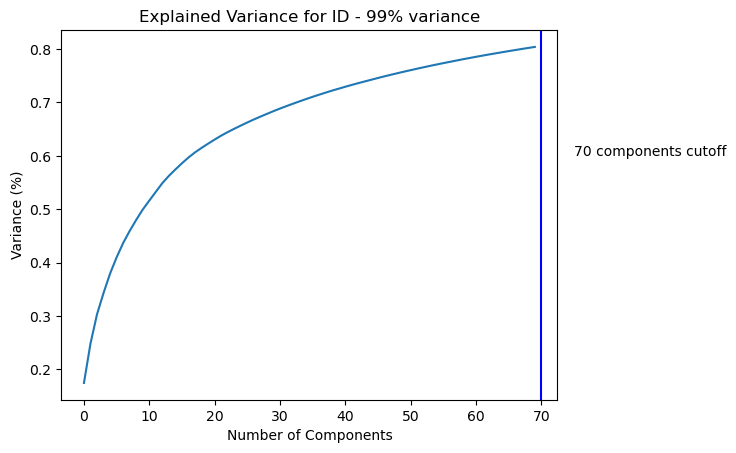

In [18]:
# Plot variance vs number of components
plt.figure()
plt.plot(np.cumsum(id_pca_cat.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Variance (%)")  # for each component
plt.title("Explained Variance for ID - 99% variance")
# vertical line at 70
plt.axvline(x=70, c="b")
# label the line
plt.text(75, 0.6, "70 components cutoff")
plt.show()

In [19]:
print("Number of components: ", id_n_components)

Number of components:  70


### Final Model SVC


In [20]:
id_final = SVC(kernel="rbf", C=20, gamma="scale", degree=5)
id_final.fit(id_x_train_pca, id_y_train_cat)

SVC(C=20, degree=5)

In [21]:
precision_recall_fscore_svc_final, cm_final = validate_model(
    id_final, id_x_valid_pca, id_y_valid_cat
)

print("Precision, Recall and F1 Score:", precision_recall_fscore_svc_final)

Accuracy:  0.948
Confusion matrix: 
[[12  0  0 ...  0  0  0]
 [ 0  9  0 ...  0  0  0]
 [ 0  0 12 ...  0  0  0]
 ...
 [ 0  0  0 ... 20  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0 10]]
Precision, recall, f1-score: 
Precision, Recall and F1 Score: (0.9519632041161453, 0.948, 0.9480309340405871, None)


In [22]:
id_final_train_preds = id_final.predict(id_x_train_pca)
pd.DataFrame(id_final_train_preds, columns=["label_1"]).to_csv(
    "id_final_train_preds.csv"
)
id_final_test_preds = id_final.predict(id_x_test_pca)
pd.DataFrame(id_final_test_preds, columns=["label_1"]).to_csv(
    "id_final_test_preds.csv")
id_final_valid_preds = id_final.predict(id_x_valid_pca)
pd.DataFrame(id_final_valid_preds, columns=["label_1"]).to_csv(
    "id_final_valid_preds.csv"
)


# Label 2


{'kernel': 'rbf', 'gamma': 0.001, 'degree': 5, 'C': 10}


In [23]:
# Handling NaN values in the age
# Combine X and y into a single DataFrame

age_data_train_cat = pd.concat([x_train_scaled, age_train], axis=1)
age_data_valid_cat = pd.concat([x_valid_scaled, age_valid], axis=1)

# Remove rows with null values
age_data_cleaned_train_cat = age_data_train_cat.dropna()
age_data_cleaned_valid_cat = age_data_valid_cat.dropna()

# Separate X and y again
age_x_train_cat = age_data_cleaned_train_cat.drop(columns=["label_2"])
age_y_train_cat = age_data_cleaned_train_cat["label_2"]
age_x_valid_cat = age_data_cleaned_valid_cat.drop(columns=["label_2"])
age_y_valid_cat = age_data_cleaned_valid_cat["label_2"].to_frame()

age_x_test_cat = x_test_scaled

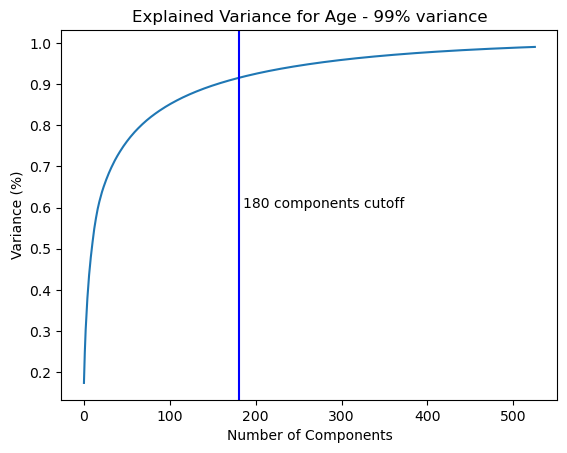

In [24]:
age_x_train_pca, age_x_valid_pca, age_n_components, age_pca_cat = do_pca(
    age_x_train_cat, age_x_valid_cat
)

# Plot variance vs number of components
plt.figure()
plt.plot(np.cumsum(age_pca_cat.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Variance (%)")  # for each component
plt.title("Explained Variance for Age - 99% variance")
# vertical line at 70
plt.axvline(x=180, c="b")
# label the line
plt.text(185, 0.6, "180 components cutoff")
plt.show()

In [25]:
age_x_train_pca, age_x_valid_pca, age_n_components, age_pca_cat = do_pca(
    age_x_train_cat, age_x_valid_cat, n_components=180
)
age_x_test_pca = pd.DataFrame(
    age_pca_cat.transform(age_x_test_cat),
    columns=["feature_pca_" + str(i) for i in range(1, age_n_components + 1)],
)

In [26]:
age_final = SVC(**{"kernel": "rbf", "gamma": "scale", "degree": 5, "C": 30})
age_final.fit(age_x_train_pca, age_y_train_cat)


SVC(C=30, degree=5)

In [27]:
age_precision_recall_fscore_svc_final, age_cm_final = validate_model(
    age_final, age_x_valid_pca, age_y_valid_cat
)

print("Precision, Recall and F1 Score:", age_precision_recall_fscore_svc_final)

Accuracy:  0.9415760869565217
Confusion matrix: 
[[ 35   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  68   1   1   1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1  45   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   6   0  68   3   0   0   0   0   1   0   1   0   0   0   0   0]
 [  0   1   0   1 111   0   0   1   0   1   0   0   0   0   0   0   0]
 [  0   1   0   1   1  76   0   0   0   2   0   0   0   0   0   0   0]
 [  1   1   1   0   1   1  41   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0  44   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   1   1   0   0  46   0   0   0   0   0   0   0   0]
 [  0   1   1   0   0   1   0   0   0  62   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  11   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0  29   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0  10   0   0   0   0]
 [  0   0   0   1   0   0   

In [28]:
age_final_test_preds = age_final.predict(age_x_test_pca)
pd.DataFrame(age_final_test_preds, columns=["label_1"]).to_csv(
    "age_final_test_preds.csv"
)
age_final_train_preds = age_final.predict(age_x_train_pca)
pd.DataFrame(age_final_train_preds, columns=["label_1"]).to_csv(
    "age_final_train_preds.csv"
)
age_final_valid_preds = age_final.predict(age_x_valid_pca)
pd.DataFrame(age_final_valid_preds, columns=["label_1"]).to_csv(
    "age_final_valid_preds.csv"
)

# Label 3 - Gender


In [29]:
# Handling NaN values in the age
# Combine X and y into a single DataFrame

gender_data_train_cat = pd.concat([x_train_scaled, gender_train], axis=1)
gender_data_valid_cat = pd.concat([x_valid_scaled, gender_valid], axis=1)

# Remove rows with null values
gender_data_cleaned_train_cat = gender_data_train_cat.dropna()
gender_data_cleaned_valid_cat = gender_data_valid_cat.dropna()

# Separate X and y again
gender_x_train_cat = gender_data_cleaned_train_cat.drop(columns=["label_3"])
gender_y_train_cat = gender_data_cleaned_train_cat["label_3"]
gender_x_valid_cat = gender_data_cleaned_valid_cat.drop(columns=["label_3"])
gender_y_valid_cat = gender_data_cleaned_valid_cat["label_3"].to_frame()

gender_x_test_cat = x_test_scaled


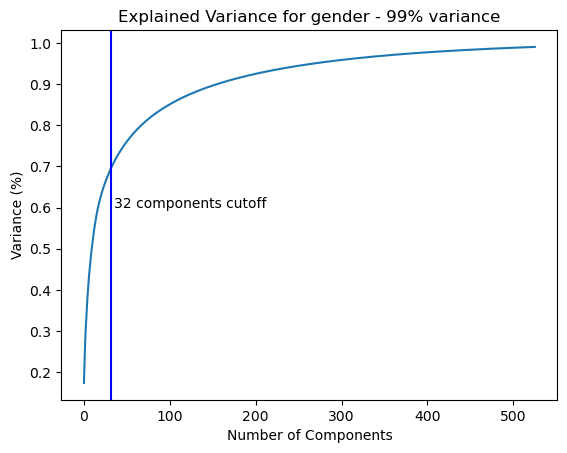

In [30]:
gender_x_train_pca, gender_x_valid_pca, gender_n_components, gender_pca_cat = do_pca(
    gender_x_train_cat, gender_x_valid_cat
)

# Plot variance vs number of components
plt.figure()
plt.plot(np.cumsum(gender_pca_cat.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Variance (%)")  # for each component
plt.title("Explained Variance for gender - 99% variance")
# vertical line at 70
plt.axvline(x=32, c="b")
# label the line
plt.text(35, 0.6, "32 components cutoff")
plt.show()

In [31]:
gender_x_train_pca, gender_x_valid_pca, gender_n_components, gender_pca_cat = do_pca(
    gender_x_train_cat, gender_x_valid_cat, n_components=32
)
gender_x_test_pca = pd.DataFrame(
    gender_pca_cat.transform(gender_x_test_cat),
    columns=["feature_pca_" + str(i)
             for i in range(1, gender_n_components + 1)],
)


In [32]:
gender_final = SVC(kernel="rbf", C=10, gamma="scale")
gender_final.fit(gender_x_train_pca, gender_y_train_cat)

SVC(C=10)

In [33]:
gender_precision_recall_fscore_svc_final, gender_cm_final = validate_model(
    gender_final, gender_x_valid_pca, gender_y_valid_cat
)

print("Precision, Recall and F1 Score:", gender_precision_recall_fscore_svc_final)

Accuracy:  0.9946666666666667
Confusion matrix: 
[[141   1]
 [  3 605]]
Precision, recall, f1-score: 
Precision, Recall and F1 Score: (0.9947178217821782, 0.9946666666666667, 0.9946809214947601, None)


In [34]:
gender_final_test_preds = gender_final.predict(gender_x_test_pca)
pd.DataFrame(gender_final_test_preds, columns=["label_1"]).to_csv(
    "gender_final_test_preds.csv"
)
gender_final_train_preds = gender_final.predict(gender_x_train_pca)
pd.DataFrame(gender_final_train_preds, columns=["label_1"]).to_csv(
    "gender_final_train_preds.csv"
)
gender_final_valid_preds = gender_final.predict(gender_x_valid_pca)
pd.DataFrame(gender_final_valid_preds, columns=["label_1"]).to_csv(
    "gender_final_valid_preds.csv"
)

# Label 4


In [5]:
# Handling NaN values in the age
# Combine X and y into a single DataFrame

accent_data_train_cat = pd.concat([x_train_scaled, accent_train], axis=1)
accent_data_valid_cat = pd.concat([x_valid_scaled, accent_valid], axis=1)

# Remove rows with null values
accent_data_cleaned_train_cat = accent_data_train_cat.dropna()
accent_data_cleaned_valid_cat = accent_data_valid_cat.dropna()

# Separate X and y again
accent_x_train_cat = accent_data_cleaned_train_cat.drop(columns=["label_4"])
accent_y_train_cat = accent_data_cleaned_train_cat["label_4"]
accent_x_valid_cat = accent_data_cleaned_valid_cat.drop(columns=["label_4"])
accent_y_valid_cat = accent_data_cleaned_valid_cat["label_4"].to_frame()

accent_x_test_cat = x_test_scaled


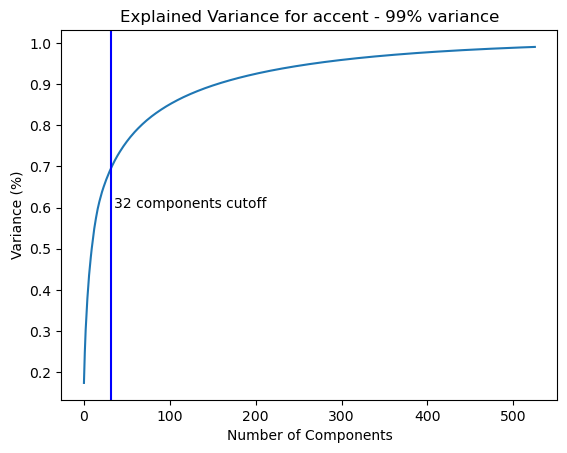

In [36]:
accent_x_train_pca, accent_x_valid_pca, accent_n_components, accent_pca_cat = do_pca(
    accent_x_train_cat, accent_x_valid_cat
)

# Plot variance vs number of components
plt.figure()
plt.plot(np.cumsum(accent_pca_cat.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Variance (%)")  # for each component
plt.title("Explained Variance for accent - 99% variance")
# vertical line at 70
plt.axvline(x=32, c="b")
# label the line
plt.text(35, 0.6, "32 components cutoff")
plt.show()

In [37]:
accent_x_train_pca, accent_x_valid_pca, accent_n_components, accent_pca_cat = do_pca(
    accent_x_train_cat, accent_x_valid_cat, n_components=130
)
accent_x_test_pca = pd.DataFrame(
    accent_pca_cat.transform(accent_x_test_cat),
    columns=["feature_pca_" + str(i) for i in range(1, accent_n_components + 1)],
)

In [38]:
accent_final = SVC(kernel="rbf", C=10, gamma="scale")
accent_final.fit(accent_x_train_pca, accent_y_train_cat)

SVC(C=10)

In [39]:
accent_precision_recall_fscore_svc_final, accent_cm_final = validate_model(
    accent_final, accent_x_valid_pca, accent_y_valid_cat
)

print("Precision, Recall and F1 Score:", accent_precision_recall_fscore_svc_final)

Accuracy:  0.9746666666666667
Confusion matrix: 
[[ 21   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  11   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0  25   0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   8   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  13   0   2   0   0   0   0   0   0   0]
 [  0   0   0   0   0  10   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1 531   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   4  28   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1   0  18   0   0   0   0   0]
 [  0   0   0   0   0   0   3   0   0  14   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   9   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0  10   0   0]
 [  0   0   0   0   0   0   3   0   0   0   0   0  23   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  10]]
Precision, recall, f1-score: 
Precision, Recall and F1 Score: (0.9753890732138907, 0.9746666666666667, 0.9741348012603647, N

In [40]:
accent_final_test_preds = accent_final.predict(accent_x_test_pca)
pd.DataFrame(accent_final_test_preds, columns=["label_1"]).to_csv(
    "accent_final_test_preds.csv"
)
accent_final_train_preds = accent_final.predict(accent_x_train_pca)
pd.DataFrame(accent_final_train_preds, columns=["label_1"]).to_csv(
    "accent_final_train_preds.csv"
)
accent_final_valid_preds = accent_final.predict(accent_x_valid_pca)
pd.DataFrame(accent_final_valid_preds, columns=["label_1"]).to_csv(
    "accent_final_valid_preds.csv"
)

In [8]:
# A sklearn pipeline to do the above steps
from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    [("pca", PCA(n_components=130)), ("model", SVC(kernel="rbf", C=10, gamma="scale"))]
)

pipeline.fit(accent_x_train_cat, accent_y_train_cat)

accent_precision_recall_fscore_svc_final, accent_cm_final = validate_model(
    pipeline, accent_x_valid_cat, accent_y_valid_cat
)

Accuracy:  0.9813333333333333
Confusion matrix: 
[[ 21   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  11   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0  26   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   8   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  13   0   2   0   0   0   0   0   0   0]
 [  0   0   0   0   0  10   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 532   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1  31   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1   0  18   0   0   0   0   0]
 [  0   0   0   0   0   0   3   0   0  14   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   9   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0  10   0   0]
 [  0   0   0   0   0   0   3   0   0   0   0   0  23   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  10]]
Precision, recall, f1-score: 
